In [1]:
%matplotlib inline

import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# The following import and function call are the only additions to code required
# to automatically log metrics and parameters to MLflow.
import mlflow.keras

mlflow.keras.autolog()

latent_dim = 100
height = 32
width = 32
channels = 3


Using TensorFlow backend.


In [2]:
# ----------------- The GAN Generator Network
def define_generator(latent_dim):
    
    generator_input = keras.Input(shape=(latent_dim,))

    x = layers.Dense(256 * 16 * 16)(generator_input)
    x = layers.LeakyReLU()(x)
    # Transforms the input into a 16x16 128-channel feature map
    x = layers.Reshape((16, 16, 256))(x)
    
    x = layers.Conv2D(256, 5, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    # Upscale to 32x32
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 5, padding = 'same')(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 5, padding = 'same')(x)
    x = layers.LeakyReLU()(x)
    
    # Produces a 32x32 1-channel feature map (shape of a Traffic-Sign image)
    x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
    
    # Instantiates a generator model, which maps the input of shape (latent_dim) into an image of shape (32, 32, 3)
    generator = keras.models.Model(generator_input, x)
    generator.summary()

    return generator

# create the generator
g_model = define_generator(latent_dim)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       1638656   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 128)       524416    
__________

In [3]:
# ----------------- The GAN Discriminator Network
def define_discriminator(in_shape=(32,32,3)):

    discriminator_input = keras.Input(shape=(height, width, channels))
    x = layers.Conv2D(64, 3)(discriminator_input)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 3, strides=2)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(128, 3, strides=2)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(256, 3, strides=2)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)
    
    discriminator = keras.models.Model(discriminator_input,x)
    discriminator.summary()
    
    #discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
    discriminator_optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
    
    discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

    return discriminator


# create the discriminator
d_model = define_discriminator()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         147584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [4]:
# ----------------- Adversarial Network
def define_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = keras.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    
    gan = keras.models.Model(gan_input, gan_output)
    gan.summary()
    
    #gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
    gan_optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.5)
    
    gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

    return gan


# create the gan
gan_model = define_gan(g_model, d_model)


In [5]:
# Access files on the google drive
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)


In [6]:
# Path variables to access project relevant files
#root_dir = "/content/gdrive/My Drive/"
#base_dir = root_dir + 'Colab Notebooks/SDC_Traffic_Sign/'

base_dir = './'


Load the German Traffic-Sign dataset.

Re-scaling the input in the range [0,1]. This is done in order to scale the gradients to a manageable level. RGB images are represented by numbers ranging from 0 to 255. This would require large numbers in the weight matrices of a neural network, with correspondingly high gradients. This would make training very difficult using gradient-descent methods.

For this project, Class 17 corresponding 'No Entry' sign is considered for image generation.

In [7]:
# Load pickled data
import pickle

# load and prepare traffic-sign training images
def load_preprocess_real_data(base_dir, class_val):

  training_file = base_dir + 'traffic-signs-data/train.p'
  testing_file = base_dir + 'traffic-signs-data/test.p'

  with open(training_file, mode='rb') as f:
    train = pickle.load(f)
  with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
  x_train, y_train = train['features'], train['labels']
  x_test, y_test = test['features'], test['labels']
  
  x_train = x_train[y_train.flatten() == class_val]
  x_test = x_test[y_test.flatten() == class_val]
  
  x_train = np.concatenate([x_train, x_test])
  
  x_train = x_train.reshape((x_train.shape[0],)+(height, width, channels))

  x_train = x_train.astype('float32') / 255.

  return x_train


# load image data

class_val = 17
dataset = load_preprocess_real_data(base_dir, class_val)
len(dataset)


1470

In [9]:
# train the generator and discriminator
def train(generator, discriminator, gan, x_train, latent_dim, base_dir):

    import os
    from keras.preprocessing import image
    from keras.preprocessing.image import ImageDataGenerator
    import random

    
    image_gen = ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range = 0.01,
            zoom_range = [0.9, 1.25],
            horizontal_flip=True,
            data_format = 'channels_last')
        
    iterations = 12000
    batch_size = 20
    step = 9900
    
    n = len(x_train)
    r = n % batch_size
    x_train = x_train[:(n-r)]
        
    for X_batch in image_gen.flow(x_train, batch_size=batch_size, shuffle=True):

        if (len(X_batch) < batch_size):
          break

        #1. Draw random points in the latent space (random noise).
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        #2. Generate images with generator using this random noise.
        generated_images = generator.predict(random_latent_vectors)

        #3. Mix the generated images with real ones.
        combined_images = np.concatenate([generated_images, X_batch])

        #4. Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        labels += 0.05 * np.random.random(labels.shape)

        # Randomise real images before training

        d_loss = discriminator.train_on_batch(combined_images, labels)

        #5. Draw new random points in the latent space.
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

        #6. Train gan using these random vectors, with targets that all say “these are real images.”
        misleading_targets = np.zeros((batch_size, 1))

        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        if step % 100 == 0:

          # save weights of all three models periodically
          d_file = base_dir + 'weights/discriminator_%03d.h5' % (step)
          discriminator.save_weights(d_file)
          g_file = base_dir + 'weights/generator_%03d.h5' % (step)
          generator.save_weights(g_file)
          gan_file = base_dir + 'weights/gan_%03d.h5' % (step)
          gan.save_weights(gan_file)

          # Evaluate network performance
          #(acc_real, acc_fake) = evaluate_accuracy(generator, discriminator, x_train, latent_dim, n_samples=150)
          #print('Iter # ', step, '\t', 'd_loss: %.0f%%', d_loss, '\t', 'd_acc: %.0f%%', acc_real, '\t', 'a loss: %.0f%%', a_loss, '\t', 'a acc: %.0f%%', acc_fake)
          #print('Iter # ', step, '\t', 'discriminator loss: %.0f%' % (d_loss), '\t', 'adversarial loss: %.0f%' % (a_loss))
          print('Iter # ', step, '\t', 'discriminator loss:', d_loss, '\t', 'adversarial loss:', a_loss)

          img = image.array_to_img(generated_images[0] * 255., scale=False)
          img.save(os.path.join(base_dir + 'images/', 'generated_noentry' + str(step) + '.png'))

          img = image.array_to_img(X_batch[0] * 255., scale=False)
          img.save(os.path.join(base_dir + 'images/', 'real_noentry' + str(step) + '.png'))


        step += 1

        if step >= iterations:
          # we need to break the loop by hand because
          # the generator loops indefinitely
          break          



In [10]:
'''
'''
# Restore saved weights
g_file = base_dir + 'weights/generator_9900.h5'
g_model.load_weights(g_file)

d_file = base_dir + 'weights/discriminator_9900.h5'
d_model.load_weights(d_file)

gan_file = base_dir + 'weights/gan_9900.h5'
gan_model.load_weights(gan_file)






In [11]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, base_dir)


/home/raghu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:
/home/raghu/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Iter #  9900 	 discriminator loss: 0.6997746 	 adversarial loss: 0.7300164
Iter #  10000 	 discriminator loss: 0.68647146 	 adversarial loss: 0.80038404
Iter #  10100 	 discriminator loss: 0.69824445 	 adversarial loss: 0.7390699
Iter #  10200 	 discriminator loss: 0.69357663 	 adversarial loss: 0.7112037
Iter #  10300 	 discriminator loss: 0.6964508 	 adversarial loss: 0.7638741
Iter #  10400 	 discriminator loss: 0.69321996 	 adversarial loss: 0.7210959
Iter #  10500 	 discriminator loss: 0.6931275 	 adversarial loss: 0.7526306
Iter #  10600 	 discriminator loss: 0.6928373 	 adversarial loss: 0.75510097
Iter #  10700 	 discriminator loss: 0.6891819 	 adversarial loss: 0.7530235
Iter #  10800 	 discriminator loss: 0.6952117 	 adversarial loss: 0.76364356
Iter #  10900 	 discriminator loss: 0.68696564 	 adversarial loss: 0.7386247
Iter #  11000 	 discriminator loss: 0.6944739 	 adversarial loss: 0.76364166
Iter #  11100 	 discriminator loss: 0.692478 	 adversarial loss: 0.7172553
Iter 

In [16]:
import os
import glob
import matplotlib.image as mpimg # for loading in images

# Helper function to create a list object that holds images.
# These images are currently available in the local system folders
def load_dataset(image_dir, im_type):
    
    # Populate this empty image list
    im_list = []
    
    # Iterate through the folder
    path = os.path.join(image_dir, im_type + "*.png")
    print ("image path", path)
    
    for file in glob.glob(path):
            
        # Read in the image
        im = mpimg.imread(file)
            
        # Check if the image exists/if it's been correctly read-in
        if not im is None:
            im_list.append(im)

    return im_list

  
image_dir = base_dir + 'images/'

real_all = load_dataset(image_dir, "real")
generated_all = load_dataset(image_dir, "generated")
len(real_all)


gdrive image path ./images/real*.png
gdrive image path ./images/generated*.png


21

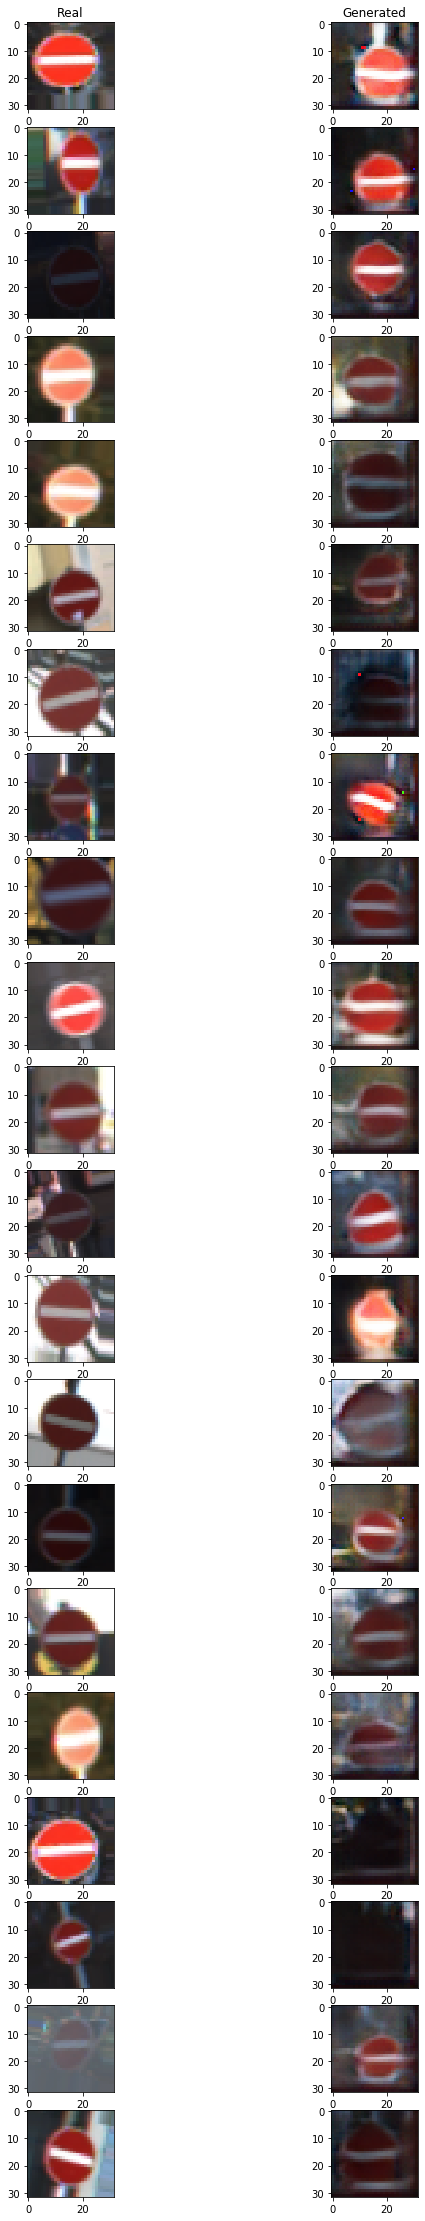

In [20]:
# Functionality to view real and generated images
# These images were saved in the native system folders during network training
import matplotlib.pyplot as plt

n = len(real_all)

real = real_all[(n-10):]
generated = generated_all[(n-10):]

# Plot the original image and the three channels
f, ax = plt.subplots(21, 2, figsize=(10,40))

ax[0,0].set_title('Real')
ax[0,1].set_title('Generated')

for i in range (len(real_all)):

    ax[i,0].imshow(real_all[i])

    ax[i,1].imshow(generated_all[i])


In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):

  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)

  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):

  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)

  # predict outputs
  X = g_model.predict(x_input)

  # create 'fake' class labels (0)
  y = np.zeros((n_samples, 1))
  return (X, y)



In [14]:
X_fake, _ = generate_fake_samples(g_model, latent_dim, n_samples=20)

len(X_fake)

20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


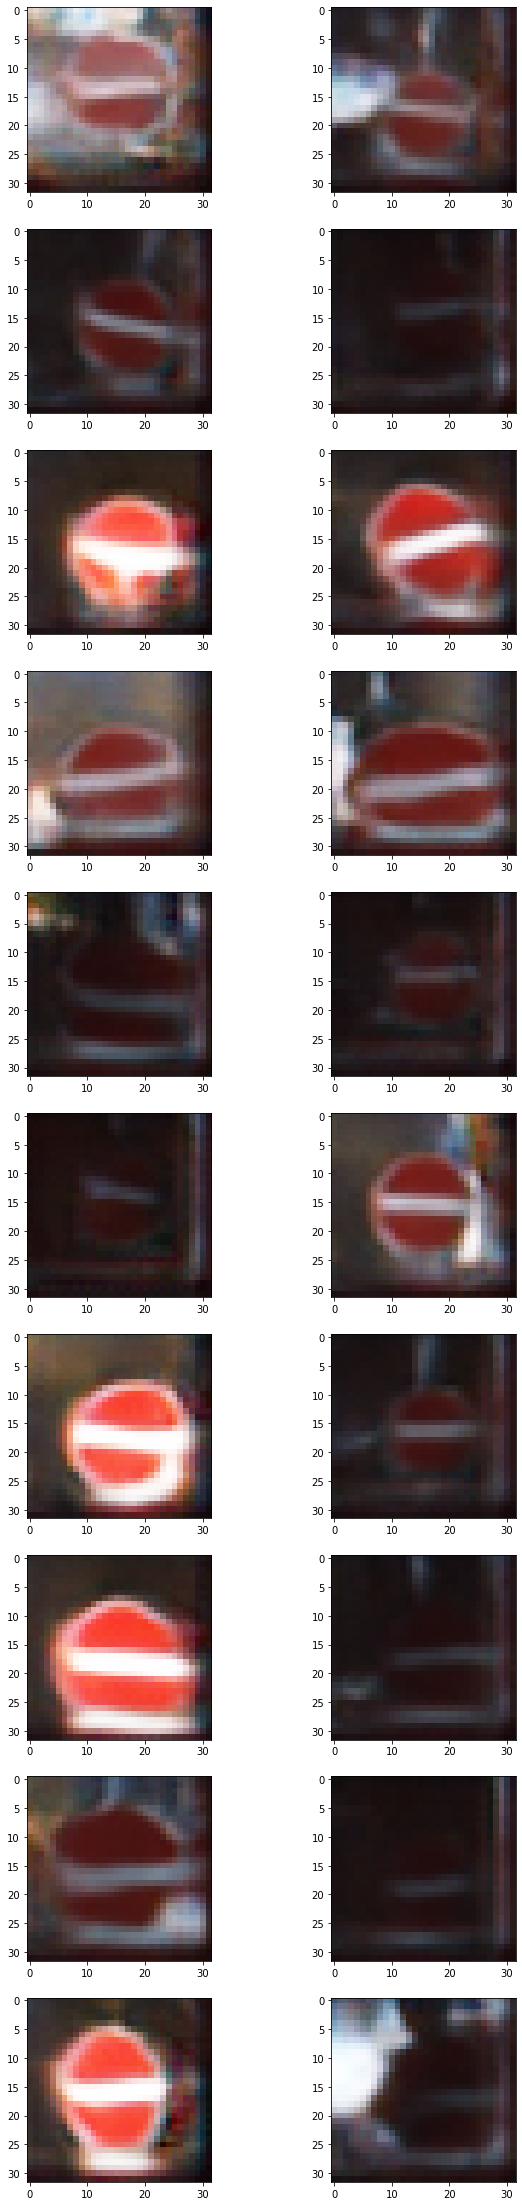

In [15]:

n = len(X_fake)

# Plot the original image and the three channels
f, ax = plt.subplots(10, 2, figsize=(10,40))

for i in range(10):
    for j in range(2):
        ax[i, j].imshow(X_fake[j+2*i])
plt.show()
